In [21]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from lime.lime_tabular import LimeTabularExplainer
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import joblib
RANDOM_STATE = 42
TARGET_COL = "Target"   

In [22]:
train = pd.read_csv('../Data/train.csv') 
test = pd.read_csv('../Data/test.csv')

X_train = train.drop(columns=[TARGET_COL])
y_train = train[TARGET_COL].astype(int)

X_test = test.drop(columns=[TARGET_COL])
y_test = test[TARGET_COL].astype(int)

print(X_train.shape, X_test.shape, y_train.value_counts().to_dict())

(5301, 40) (885, 40) {2: 1767, 0: 1767, 1: 1767}


In [23]:
pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("knn", KNeighborsClassifier())
])

# Espaço de busca:
# - k ímpares para evitar empates
# - pesos uniform vs distance
# - métrica Euclidiana (p=2) e Manhattan (p=1)
param_grid = {
    "knn__n_neighbors": [3,5,7,9,11,13,15,17,19,21,25,29,31],
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["minkowski"],
    "knn__p": [1, 2]  # 1=Manhattan, 2=Euclidiana
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

scoring = {
    "accuracy": "accuracy",
    "macro_f1": "f1_macro",
    "weighted_f1": "f1_weighted"
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring=scoring,
    refit="macro_f1",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Melhores hiperparâmetros:", grid.best_params_)
print("Melhor F1-macro (CV):", grid.best_score_)

Fitting 5 folds for each of 52 candidates, totalling 260 fits
Melhores hiperparâmetros: {'knn__metric': 'minkowski', 'knn__n_neighbors': 3, 'knn__p': 1, 'knn__weights': 'distance'}
Melhor F1-macro (CV): 0.8210293607662067


Acurácia (test): 0.6384
Macro-Precision: 0.5887 | Macro-Recall: 0.5749 | Macro-F1: 0.5780
Weighted-Precision: 0.6587 | Weighted-Recall: 0.6384 | Weighted-F1: 0.6455

Classification Report (por classe):

              precision    recall  f1-score   support

   0=Dropout     0.7316    0.5951    0.6563       284
  1=Enrolled     0.2900    0.3648    0.3231       159
  2=Graduate     0.7445    0.7647    0.7545       442

    accuracy                         0.6384       885
   macro avg     0.5887    0.5749    0.5780       885
weighted avg     0.6587    0.6384    0.6455       885



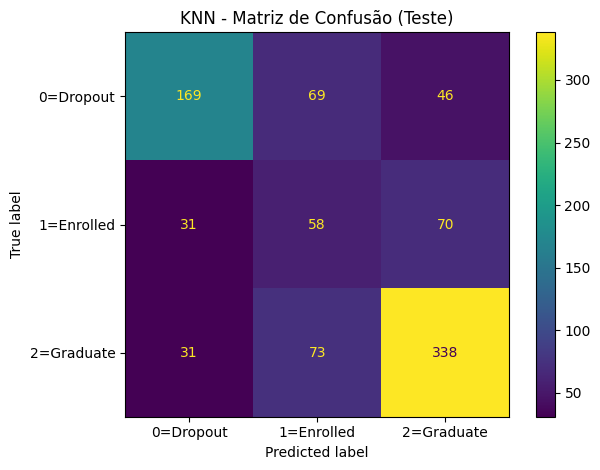

In [24]:
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)

def predict_proba_df(X):
    X_df = pd.DataFrame(X, columns=X_train.columns)
    return best_model.predict_proba(X_df)


acc = accuracy_score(y_test, y_pred)
prec, rec, f1, support = precision_recall_fscore_support(
    y_test, y_pred, average=None, labels=[0,1,2]
)
macro_prec, macro_rec, macro_f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average="macro"
)
weighted_prec, weighted_rec, weighted_f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average="weighted"
)

print(f"Acurácia (test): {acc:.4f}")
print(f"Macro-Precision: {macro_prec:.4f} | Macro-Recall: {macro_rec:.4f} | Macro-F1: {macro_f1:.4f}")
print(f"Weighted-Precision: {weighted_prec:.4f} | Weighted-Recall: {weighted_rec:.4f} | Weighted-F1: {weighted_f1:.4f}")

target_names = ["0=Dropout", "1=Enrolled", "2=Graduate"]
print("\nClassification Report (por classe):\n")
print(classification_report(y_test, y_pred, target_names=target_names, digits=4))

cm = confusion_matrix(y_test, y_pred, labels=[0,1,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(values_format="d")
plt.title("KNN - Matriz de Confusão (Teste)")
plt.tight_layout()
plt.show()

In [25]:
class_names = ["Dropout","Enrolled","Graduate"]

explainer = LimeTabularExplainer(
    training_data=X_train.values,                
    feature_names=X_train.columns.tolist(),
    class_names=class_names,
    mode="classification",
    discretize_continuous=False,
    sample_around_instance=True,
    random_state=RANDOM_STATE
)

In [26]:
mis_idx = np.where(y_pred != y_test.values)[0]
i = int(mis_idx[0]) if mis_idx.size else 0

exp = explainer.explain_instance(
    data_row=X_test.iloc[i].values,
    predict_fn=predict_proba_df, 
    num_features=10,
    top_labels=3
)

pred_label = int(y_pred[i])

In [27]:
print(f"Exemplo explicado: idx={i} | y_true={y_test.iloc[i]} | "
      f"y_pred={pred_label} ({class_names[pred_label]})")
print("\nContribuições LIME (feature -> peso local) para a classe prevista:")
for feat, w in exp.as_list(label=pred_label):
    print(f" - {feat}: {w:+.3f}")

Exemplo explicado: idx=2 | y_true=1 | y_pred=0 (Dropout)

Contribuições LIME (feature -> peso local) para a classe prevista:
 - Curricular units 2nd sem (approved): -0.088
 - Application mode: +0.065
 - Curricular units 2nd sem (grade): -0.064
 - Mother's qualification: -0.041
 - Father's occupation: -0.037
 - Course: +0.033
 - Father's qualification: -0.027
 - Gender_1: +0.027
 - Previous qualification (grade): -0.025
 - Mother's occupation: +0.012


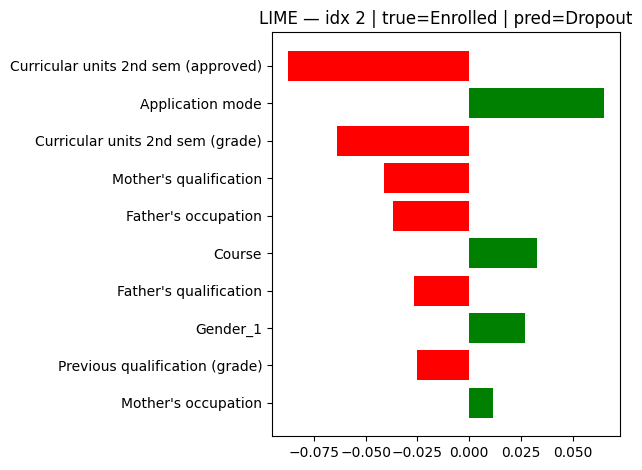

In [28]:
fig = exp.as_pyplot_figure(label=pred_label)
plt.title(f"LIME — idx {i} | true={class_names[int(y_test.iloc[i])]} | pred={class_names[pred_label]}")
plt.tight_layout()
plt.show()